In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Tanm3UMHh7RE7dmbf27O")
project = rf.workspace("project-kafxn").project("childhood-infections")
version = project.version(3)
dataset = version.download("folder")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Childhood-Infections--3 in folder:: 100%|██████████| 710/710 [00:00<00:00, 9400.02it/s]


In [ ]:
########################################### Subha, Lamia, Raisa, Shajia ####################

import numpy as np
import pandas as pd
import os
from sklearn.metrics import classification_report
import seaborn as sn
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm

class_names= ['Chickenpox', 'Hand Foot and Mouth Disease', 'Impetigo', 'Scabies']

class_names_labels={class_name:i for i, class_name in enumerate(class_names)}

print(class_names_labels)

nb_classes=len(class_names)

IMAGE_SIZE=(200,200)

def load_data():
    direct='/content/Childhood-Infections--3'
    category=['train','valid','test']

    output=[]

    for cat in category:
      path=os.path.join(direct,cat)
      print(path)

      images=[]
      labels=[]

      for folder in os.listdir(path):
        print("folder:",folder)
        label= class_names_labels[folder]

        #Iterating each image
        for fle in os.listdir(os.path.join(path,folder)):

          img_path=os.path.join(os.path.join(path,folder),fle)

          image=cv2.imread(img_path)
          image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
          image=cv2.resize(image,IMAGE_SIZE)

          images.append(image)
          labels.append(label)

      images=np.array(images,dtype='float32')
      labels=np.array(labels,dtype='int32')

      output.append((images,labels))
    #print(type(output[0]))
    return output

(train_images,train_lables), (valid_images,valid_lables), (test_images,test_lables) = load_data()

{'Chickenpox': 0, 'Hand Foot and Mouth Disease': 1, 'Impetigo': 2, 'Scabies': 3}
/content/Childhood-Infections--3/train
folder: Hand Foot and Mouth Disease
folder: Chickenpox
folder: Scabies
folder: Impetigo
/content/Childhood-Infections--3/valid
folder: Hand Foot and Mouth Disease
folder: Chickenpox
folder: Scabies
folder: Impetigo
/content/Childhood-Infections--3/test
folder: Hand Foot and Mouth Disease
folder: Chickenpox
folder: Scabies
folder: Impetigo


Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 100, 100, 32)         864       ['input_12[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 100, 100, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 100, 100, 32)         0         ['bn_Conv1[0][0]']     

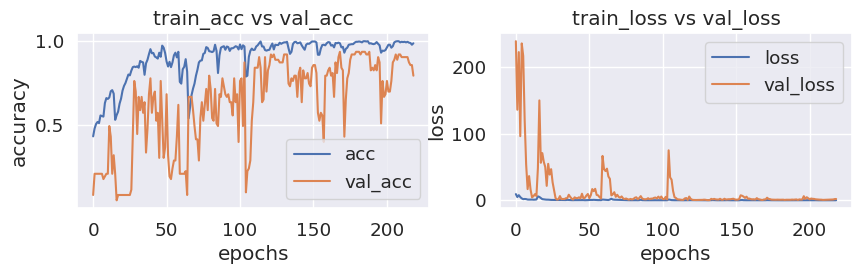

2/2 [==============================] - 0s 34ms/step


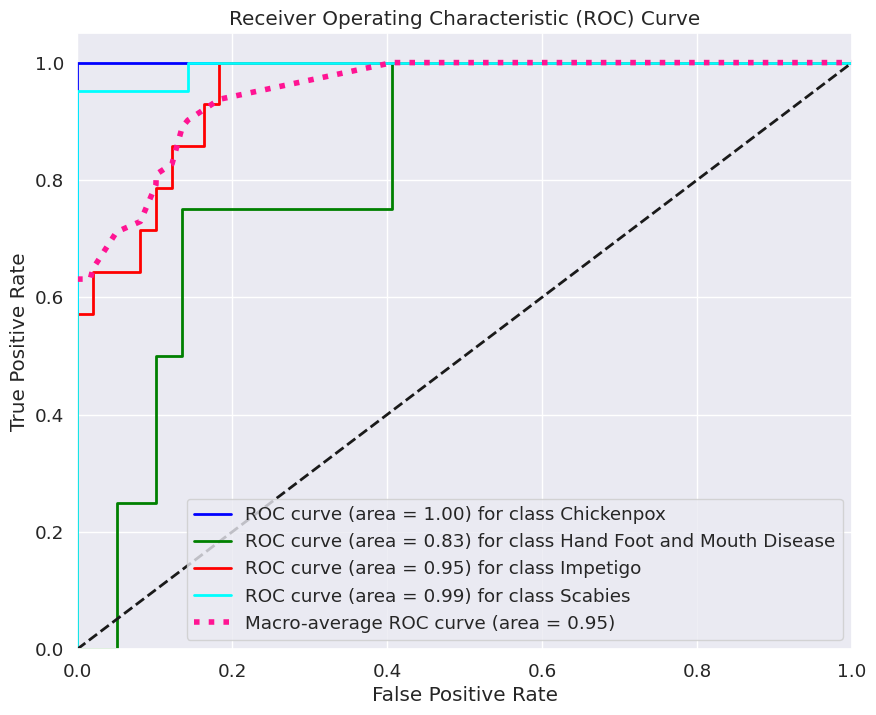

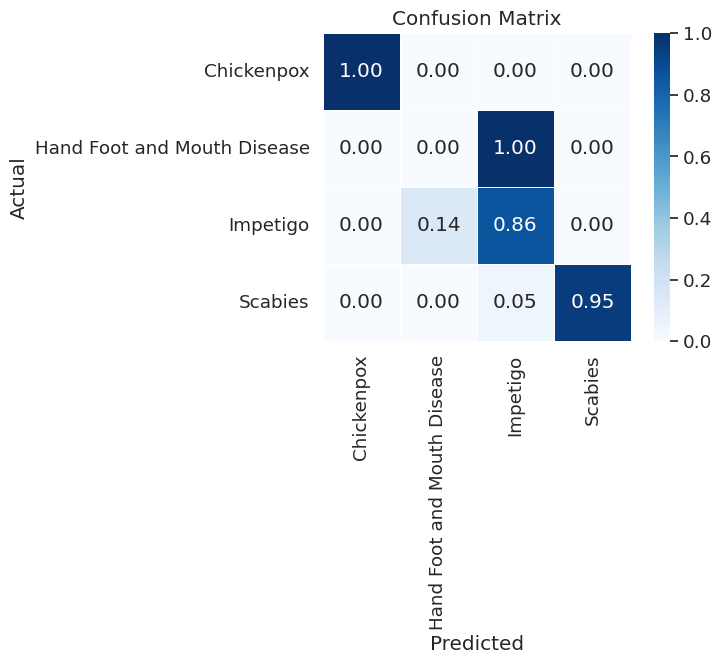

In [ ]:
########################################### Subah ####################
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate,Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(200, 200, 3))

base_model = MobileNetV2(input_tensor=input_tensor, weights='imagenet',
                    include_top=False )

x = base_model.output
x=Flatten()(x)
x= Dense(4, activation='softmax')(x)

model= Model(inputs=input_tensor, outputs=x)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
for layer in model.layers:
   layer.trainable = True
model.summary()

model_checkpoint_callback = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=50,restore_best_weights=True)

history = model.fit(train_images, train_lables, batch_size=4, epochs=500,

        validation_data=(valid_images, valid_lables), callbacks=[model_checkpoint_callback])
#callbacks = [EarlyStopping(monitor='loss', patience=5)]

test_loss=model.evaluate(test_images,test_lables)
predictions=model.predict(test_images)
pred_lables=np.argmax(predictions,axis=1)
print(classification_report(test_lables,pred_lables))

def plot_accuracy_loss(history):
  fig=plt.figure(figsize=(10,5))

  #plot accuarcy
  plt.subplot(221)
  plt.plot(history.history['accuracy'],label='acc')
  plt.plot(history.history['val_accuracy'],label='val_acc')
  plt.title('train_acc vs val_acc')
  plt.ylabel("accuracy")
  plt.xlabel("epochs")
  plt.legend()


  #plot loss
  plt.subplot(222)
  plt.plot(history.history['loss'],label='loss')
  plt.plot(history.history['val_loss'],label='val_loss')
  plt.title('train_loss vs val_loss')
  plt.ylabel("loss")
  plt.xlabel("epochs")
  plt.legend()

  plt.show()

plot_accuracy_loss(history)

########################################### Subha ####################

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import load_model

# Assuming you have test data, labels, and predictions
# test_data = ...
# test_labels = ...
# test_predictions = ...

# Number of classes
num_classes = 4

# Map class names to their corresponding numbers
class_mapping = {
'Chickenpox': 0, 'Hand Foot and Mouth Disease': 1, 'Impetigo': 2, 'Scabies': 3
}

# Reverse the mapping to get class names from numbers
class_names = {v: k for k, v in class_mapping.items()}

# Binarize the labels
y_test = label_binarize(test_lables, classes=range(num_classes))

# Load your Keras model
# model = load_model('your_model_path')

# Predict probabilities
y_score = model.predict(test_images)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Interpolate ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))

# Plot individual ROC curves
colors = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'purple', 'orange'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], class_names[i]))

# Plot macro-average ROC curve
plt.plot(fpr["macro"], tpr["macro"], color='deeppink', linestyle=':', linewidth=4, label='Macro-average ROC curve (area = {:.2f})'.format(roc_auc["macro"]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

########################################### Subha ####################
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize

    plt.figure(figsize=(len(class_names) + 2, len(class_names)))
    sns.set(font_scale=1.2)
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", linewidths=.5, square=True,
                xticklabels=class_names, yticklabels=class_names)

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')

    plt.show()

# Example usage:
# Replace y_true and y_pred with your actual and predicted labels
# Replace class_names with your class names
y_true = test_lables  # Replace with your actual labels
y_pred = pred_lables  # Replace with your predicted labels
class_names= class_names= ['Chickenpox', 'Hand Foot and Mouth Disease', 'Impetigo', 'Scabies']

plot_confusion_matrix(y_true, y_pred, class_names)



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 99, 99, 32)           864       ['input_2[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 99, 99, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 99, 99, 32)           0         ['block1_conv1_bn[0][0]'

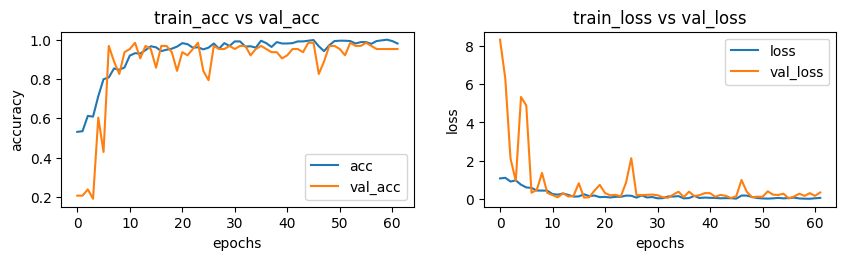

2/2 [==============================] - 0s 110ms/step


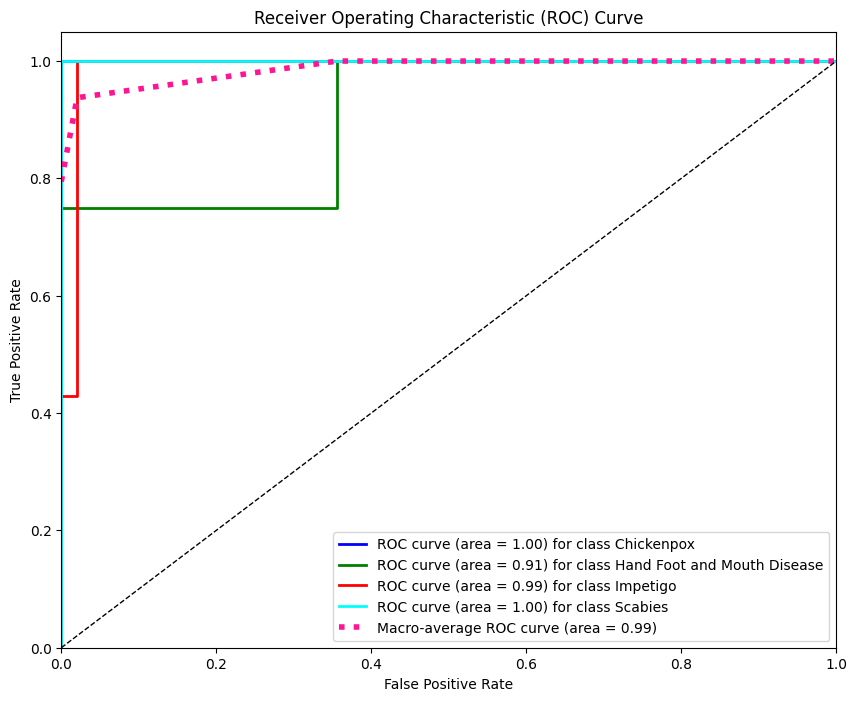

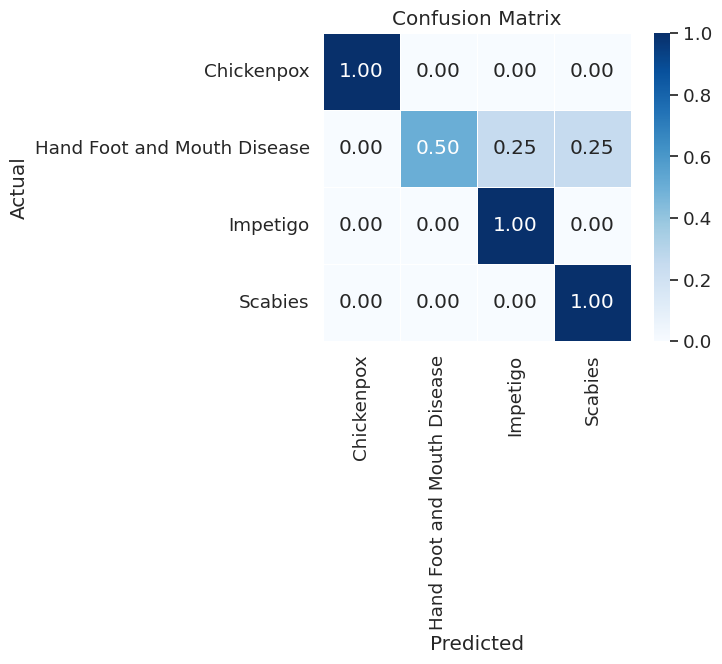

In [ ]:
########################################### Lamia ####################
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate,Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(200, 200, 3))

base_model = Xception(input_tensor=input_tensor, weights='imagenet',
                    include_top=False )

x = base_model.output
x=GlobalAveragePooling2D()(x)
x= Dense(4, activation='softmax')(x)

model= Model(inputs=input_tensor, outputs=x)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
for layer in model.layers:
   layer.trainable = True
model.summary()

model_checkpoint_callback = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=50,restore_best_weights=True)

history = model.fit(train_images, train_lables, batch_size=4, epochs=500,

        validation_data=(valid_images, valid_lables), callbacks=[model_checkpoint_callback])
#callbacks = [EarlyStopping(monitor='loss', patience=5)]

test_loss=model.evaluate(test_images,test_lables)
predictions=model.predict(test_images)
pred_lables=np.argmax(predictions,axis=1)
print(classification_report(test_lables,pred_lables))

def plot_accuracy_loss(history):
  fig=plt.figure(figsize=(10,5))

  #plot accuarcy
  plt.subplot(221)
  plt.plot(history.history['accuracy'],label='acc')
  plt.plot(history.history['val_accuracy'],label='val_acc')
  plt.title('train_acc vs val_acc')
  plt.ylabel("accuracy")
  plt.xlabel("epochs")
  plt.legend()


  #plot loss
  plt.subplot(222)
  plt.plot(history.history['loss'],label='loss')
  plt.plot(history.history['val_loss'],label='val_loss')
  plt.title('train_loss vs val_loss')
  plt.ylabel("loss")
  plt.xlabel("epochs")
  plt.legend()

  plt.show()

plot_accuracy_loss(history)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
from sklearn.metrics import roc_auc_score

# Assuming you have test data, labels, and predictions
# test_data = ...
# test_labels = ...
# test_predictions = ...

# Number of classes
num_classes = 4

# Map class names to their corresponding numbers
class_mapping = {
'Chickenpox': 0, 'Hand Foot and Mouth Disease': 1, 'Impetigo': 2, 'Scabies': 3
}

# Reverse the mapping to get class names from numbers
class_names = {v: k for k, v in class_mapping.items()}

# Binarize the labels
y_test = label_binarize(test_lables, classes=range(num_classes))

# Load your Keras model
# model = load_model('your_model_path')

# Predict probabilities
y_score = model.predict(test_images)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Interpolate ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))

# Plot individual ROC curves
colors = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'purple', 'orange'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], class_names[i]))

# Plot macro-average ROC curve
plt.plot(fpr["macro"], tpr["macro"], color='deeppink', linestyle=':', linewidth=4, label='Macro-average ROC curve (area = {:.2f})'.format(roc_auc["macro"]))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize

    plt.figure(figsize=(len(class_names) + 2, len(class_names)))
    sns.set(font_scale=1.2)
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", linewidths=.5, square=True,
                xticklabels=class_names, yticklabels=class_names)

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')

    plt.show()

# Example usage:
# Replace y_true and y_pred with your actual and predicted labels
# Replace class_names with your class names
y_true = test_lables  # Replace with your actual labels
y_pred = pred_lables  # Replace with your predicted labels
class_names= class_names= ['Chickenpox', 'Hand Foot and Mouth Disease', 'Impetigo', 'Scabies']

plot_confusion_matrix(y_true, y_pred, class_names)


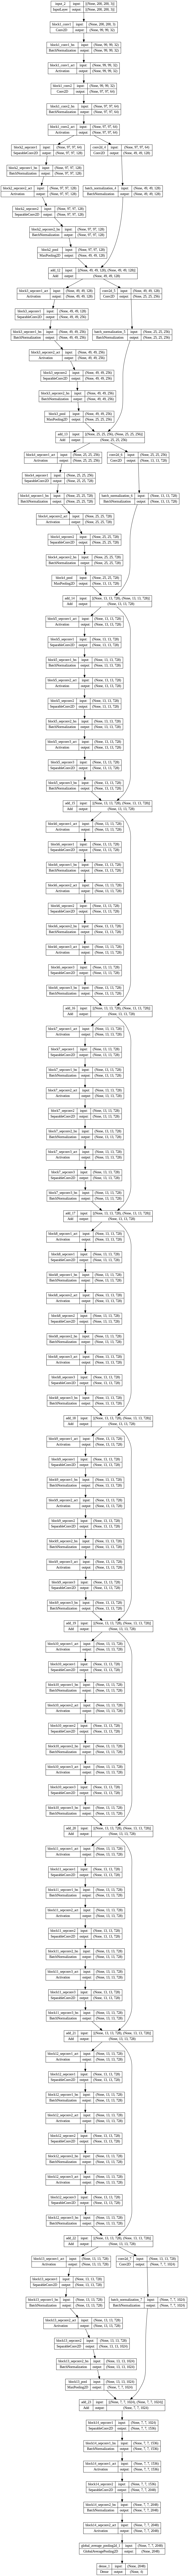

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


24274472/24274472 [==============================] - 0s 0us/step
Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 200, 200, 3)          0         ['input_16[0][0]']            
                                                                                                  
 normalization (Normalizati  (None, 200, 200, 3)          0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)       

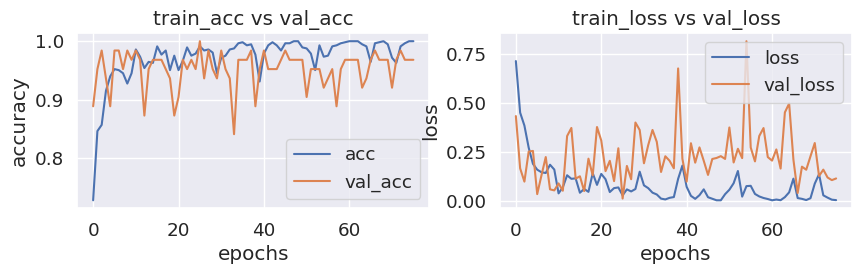

2/2 [==============================] - 0s 54ms/step


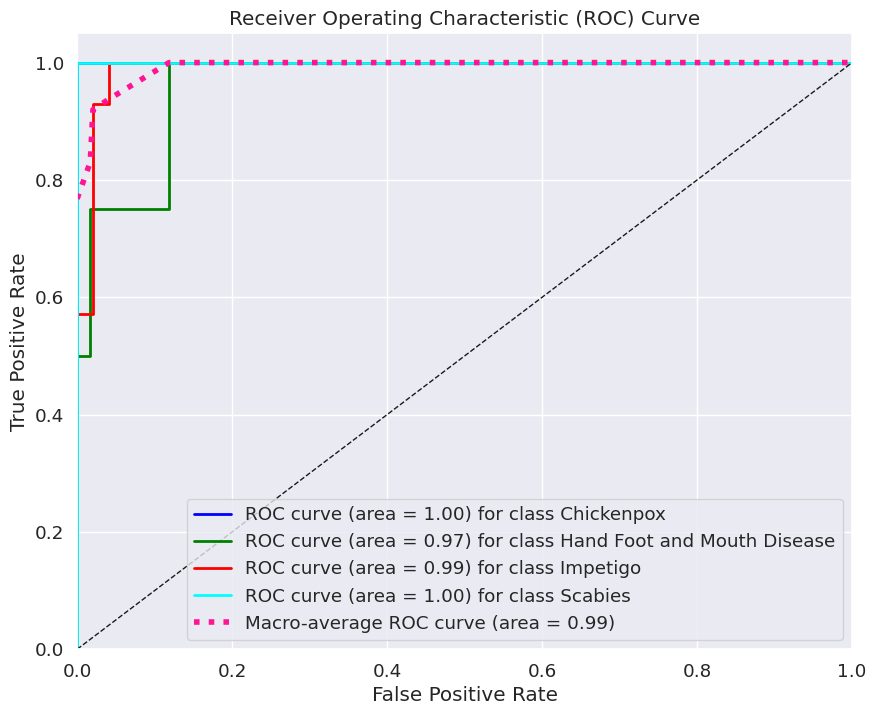

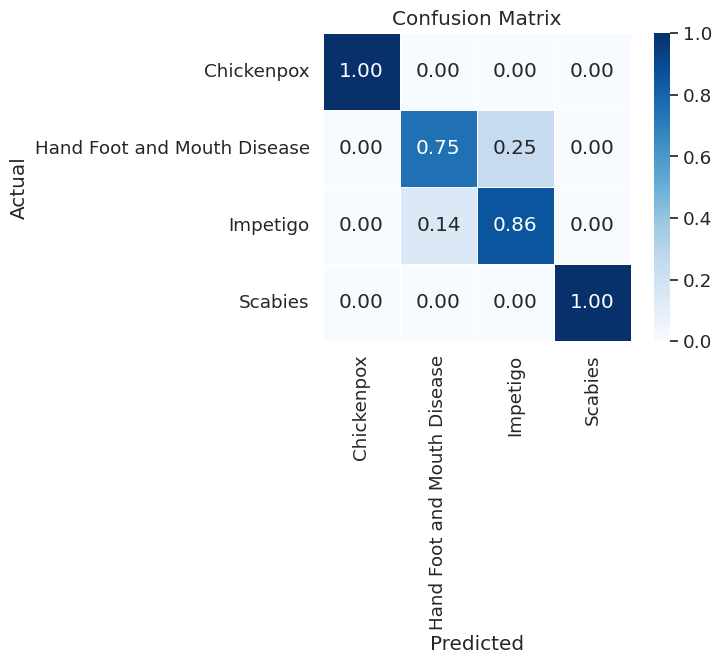

In [ ]:
########################################### Shajia ####################
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate,Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(200, 200, 3))

base_model = EfficientNetV2B0(input_tensor=input_tensor, weights='imagenet',
                    include_top=False )

x = base_model.output
x=GlobalAveragePooling2D()(x)
x= Flatten()(x)
x= Dense(4, activation='softmax')(x)

model= Model(inputs=input_tensor, outputs=x)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
for layer in model.layers:
   layer.trainable = True
model.summary()

model_checkpoint_callback = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=50,restore_best_weights=True)

history = model.fit(train_images, train_lables, batch_size=4, epochs=500,

        validation_data=(valid_images, valid_lables), callbacks=[model_checkpoint_callback])
#callbacks = [EarlyStopping(monitor='loss', patience=5)]

test_loss=model.evaluate(test_images,test_lables)
predictions=model.predict(test_images)
pred_lables=np.argmax(predictions,axis=1)
print(classification_report(test_lables,pred_lables))

def plot_accuracy_loss(history):
  fig=plt.figure(figsize=(10,5))

  #plot accuarcy
  plt.subplot(221)
  plt.plot(history.history['accuracy'],label='acc')
  plt.plot(history.history['val_accuracy'],label='val_acc')
  plt.title('train_acc vs val_acc')
  plt.ylabel("accuracy")
  plt.xlabel("epochs")
  plt.legend()


  #plot loss
  plt.subplot(222)
  plt.plot(history.history['loss'],label='loss')
  plt.plot(history.history['val_loss'],label='val_loss')
  plt.title('train_loss vs val_loss')
  plt.ylabel("loss")
  plt.xlabel("epochs")
  plt.legend()

  plt.show()

plot_accuracy_loss(history)

################################################
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
from sklearn.metrics import roc_auc_score

# Assuming you have test data, labels, and predictions
# test_data = ...
# test_labels = ...
# test_predictions = ...

# Number of classes
num_classes = 4

# Map class names to their corresponding numbers
class_mapping = {
'Chickenpox': 0, 'Hand Foot and Mouth Disease': 1, 'Impetigo': 2, 'Scabies': 3
}

# Reverse the mapping to get class names from numbers
class_names = {v: k for k, v in class_mapping.items()}

# Binarize the labels
y_test = label_binarize(test_lables, classes=range(num_classes))

# Load your Keras model
# model = load_model('your_model_path')

# Predict probabilities
y_score = model.predict(test_images)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Interpolate ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))

# Plot individual ROC curves
colors = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'purple', 'orange'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], class_names[i]))

# Plot macro-average ROC curve
plt.plot(fpr["macro"], tpr["macro"], color='deeppink', linestyle=':', linewidth=4, label='Macro-average ROC curve (area = {:.2f})'.format(roc_auc["macro"]))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
########################################################################################
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize

    plt.figure(figsize=(len(class_names) + 2, len(class_names)))
    sns.set(font_scale=1.2)
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", linewidths=.5, square=True,
                xticklabels=class_names, yticklabels=class_names)

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')

    plt.show()

# Example usage:
# Replace y_true and y_pred with your actual and predicted labels
# Replace class_names with your class names
y_true = test_lables  # Replace with your actual labels
y_pred = pred_lables  # Replace with your predicted labels
class_names= class_names= ['Chickenpox', 'Hand Foot and Mouth Disease', 'Impetigo', 'Scabies']

plot_confusion_matrix(y_true, y_pred, class_names)
